In [1]:
import pandas as pd
import re
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

In [13]:
def fft_calc(time, signal, plot=True):
    time = np.array(time)
    signal = np.array(signal)

    dt = np.mean(np.diff(time))    
    T_total = time[-1] - time[0]    
    fs = 1.0 / dt                  
    N = len(time)                

    # Remove DC (detrend)
    signal = signal - np.mean(signal)

    fft_vals = fft(signal)
    freqs = fftfreq(N, d=dt)

    # Keep only positive frequencies
    mask = freqs > 0
    freqs = freqs[mask]
    fft_power = np.abs(fft_vals[mask])**2
    
    return freqs, fft_power

In [3]:
input_file = "wan.txt"
output_dir = "runs_csv"

os.makedirs(output_dir, exist_ok=True)

with open(input_file, "r") as f:
    lines = f.readlines()

runs = {}
current_run = None
header = None
data_rows = []

for line in lines:
    line = line.strip()
    
    run_match = re.match(r"Run (\d+)", line)
    if run_match:
        if current_run is not None and header and data_rows:
            df = pd.DataFrame(data_rows, columns=header)
            runs[current_run] = df
            data_rows = []
        
        current_run = int(run_match.group(1))
        continue
    
    if line.startswith("Time"):
        header = line.split("\\t")
        continue
    
    if line.startswith("T") or line.startswith("s") or not line:
        continue
    
    if header and (line[0].isdigit() or line.startswith("0")):
        values = line.split("\\t")
        data_rows.append(values)

if current_run is not None and header and data_rows:
    df = pd.DataFrame(data_rows, columns=header)
    runs[current_run] = df

for run_number, df in runs.items():
    filename = os.path.join(output_dir, f"Run_{run_number}.csv")
    df.to_csv(filename, index=False)

print(f"Saved {len(runs)} runs into '{output_dir}/Run_X.csv' files")

Saved 17 runs into 'runs_csv/Run_X.csv' files


In [4]:
# Experiment Measurements
m1 = 4.027
m2 = 4.018

L1 = 100/100
L2 = 100/100

# l1 = 

## Spring Constant

In [5]:
# (kg, cm)
spring_data = [
    (0.019, 13.5),
    (0.049, 14.5),
    (0.1, 16.5),
    (0.199, 20.5),
    (0.497, 32)
]
g = 9.81
spring_l0 = 12.5

Hooke's Law
$$ F = kx $$
$$ mg = kx $$

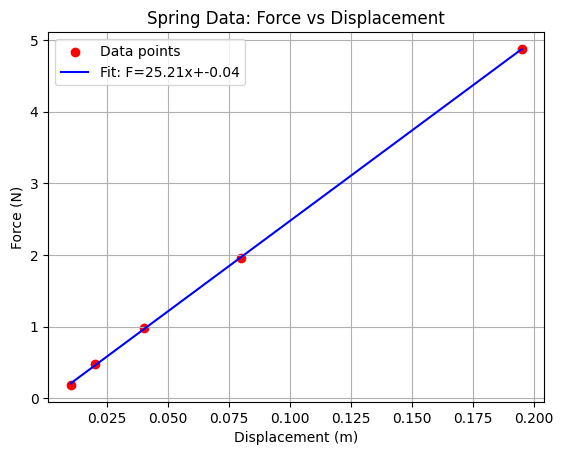

(25.21109550982422, -0.044397590134907315)

In [6]:
# plot and fit
y = np.array([d[0]*g for d in spring_data])  # Force (N)
x = np.array([(d[1]-spring_l0)/100 for d in spring_data])  # Displacement

# define linear model: Hooke's law F = kx + F0 (maybe offset)
def linear_model(x, k, F0):
    return k * x + F0

# fit model
params, covariance = curve_fit(linear_model, x, y)
k, F0 = params

# predicted values for smooth line
x_fit = np.linspace(min(x), max(x), 200)
y_fit = linear_model(x_fit, k, F0)

# plot
plt.scatter(x, y, color="red", label="Data points")
plt.plot(x_fit, y_fit, color="blue", label=f"Fit: F={k:.2f}x+{F0:.2f}")
plt.xlabel("Displacement (m)")
plt.ylabel("Force (N)")
plt.title("Spring Data: Force vs Displacement")
plt.legend()
plt.grid(True)
plt.show()

k, F0

## Vernier Data

In [7]:
# Data Labels
data_titles = {
    "Run 2":"Base Configuration (at rest)",
    "Run 4":"Base Configuration (In Phase)",
    "Run 5":"Base Configuration (Out of Phase)",
    "Run 6":"Base Configuration (Beat)",
    "Run 7":"Length Variation (at rest)",
    "Run 8":"Length Variation (In Phase)",
    "Run 9":"Length Variation (Out of Phase)",
    "Run 10":"Length Variation (Beat mode 1)",
    "Run 11":"Length Variation (Beat mode 2)",
    "Run 12":"Mass Variation (at rest)",
    "Run 13":"Mass Variation (In Phase)",
    "Run 14":"Mass Variation (Out of Phase)",
    "Run 16":"Mass Variation (Beat mode 1)",
    "Run 17":"Mass Variation (Beat mode 2)"
}

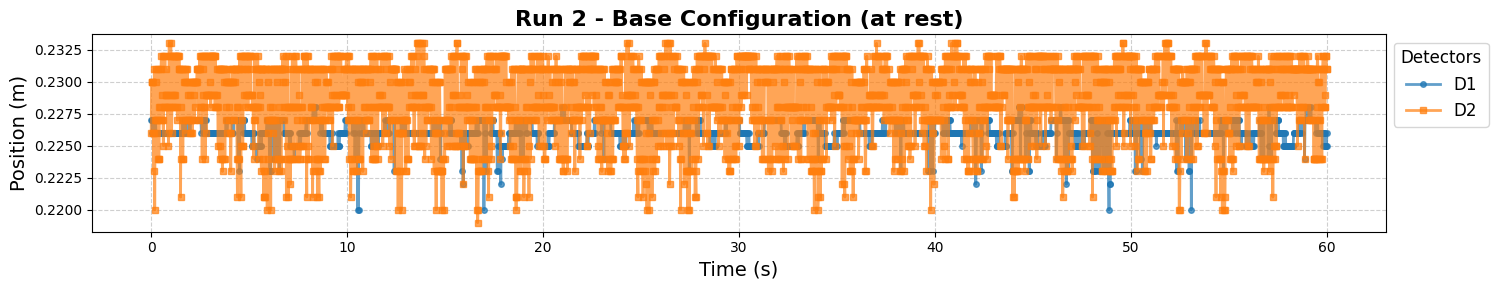

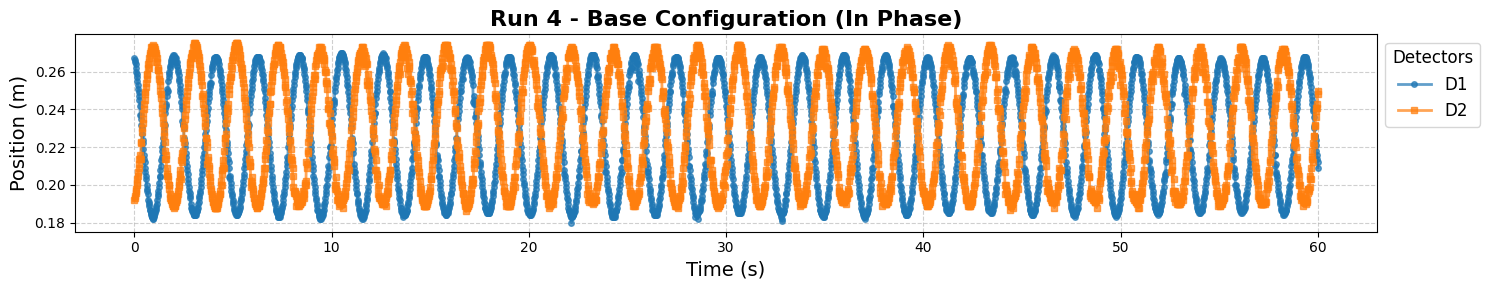

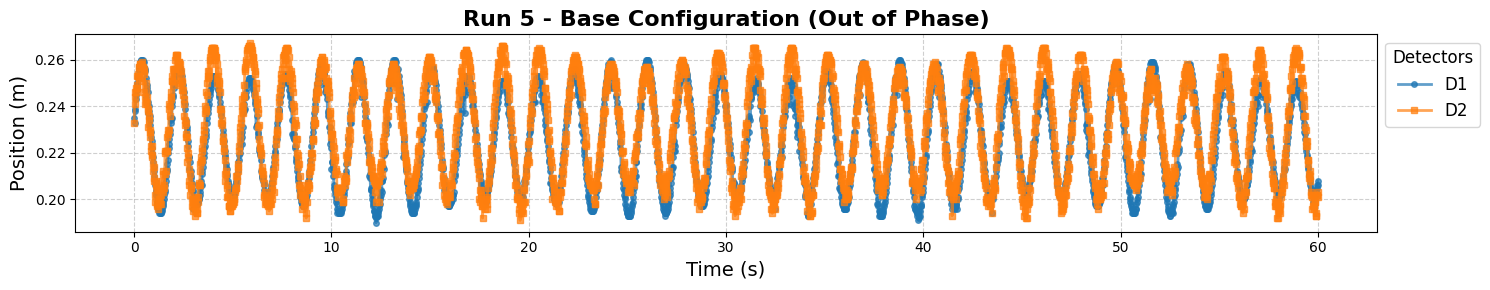

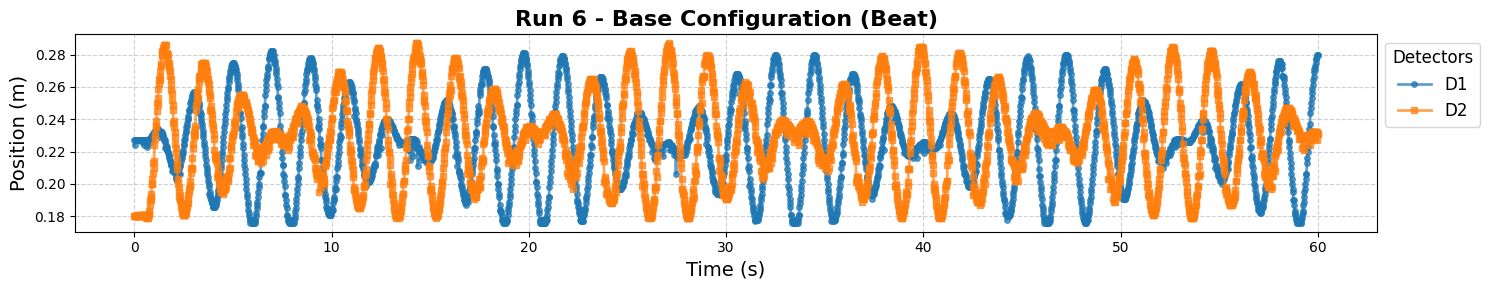

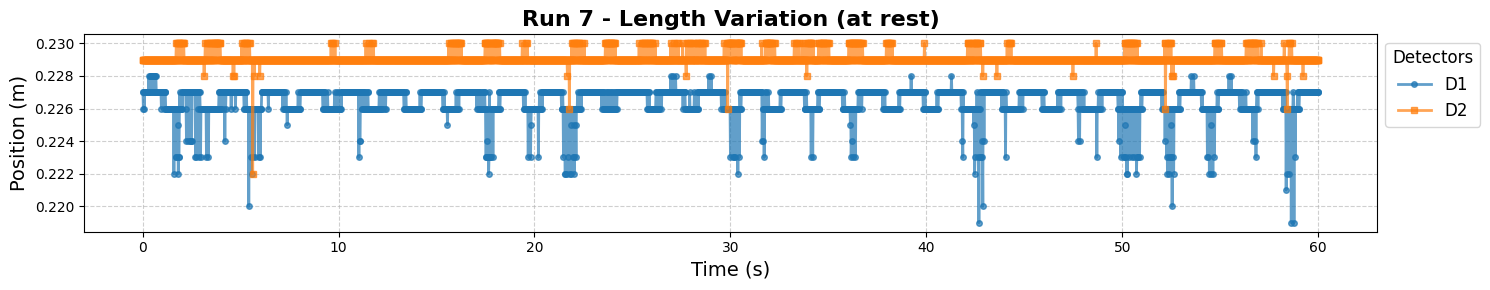

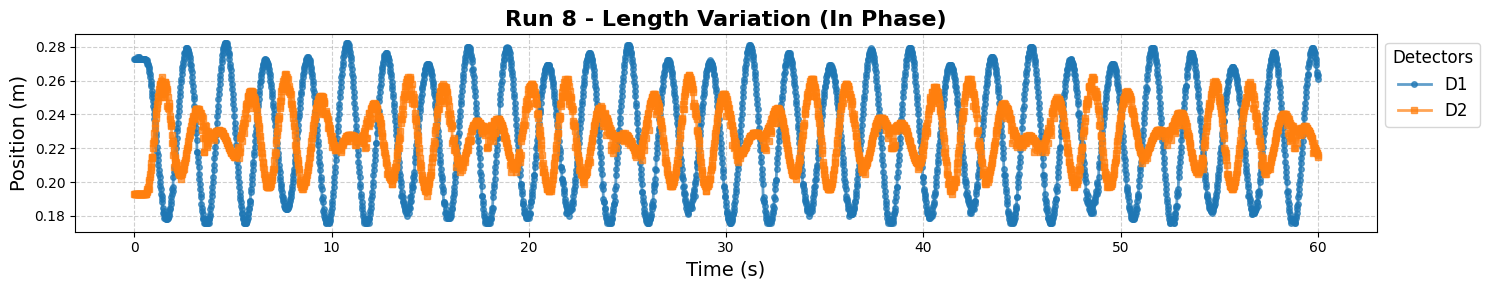

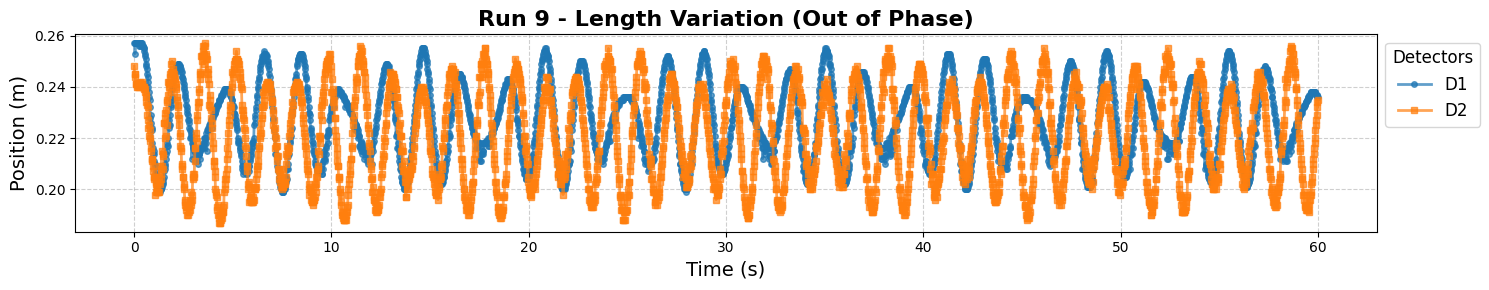

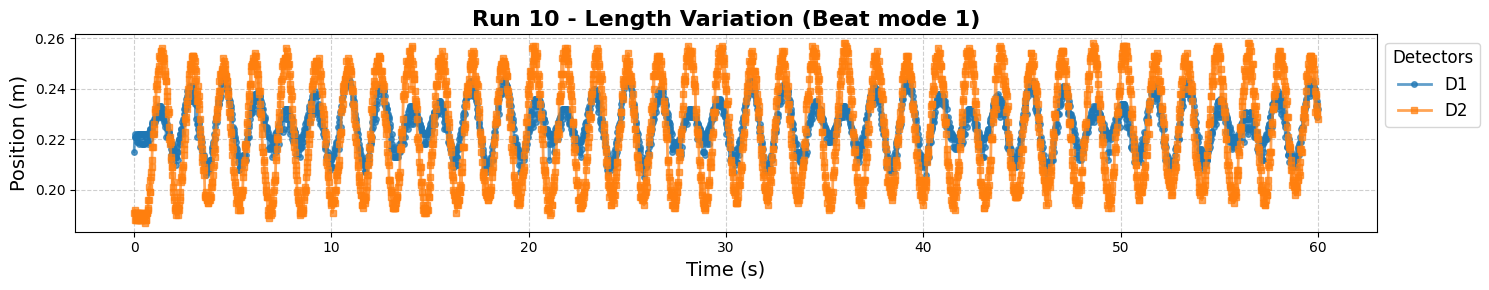

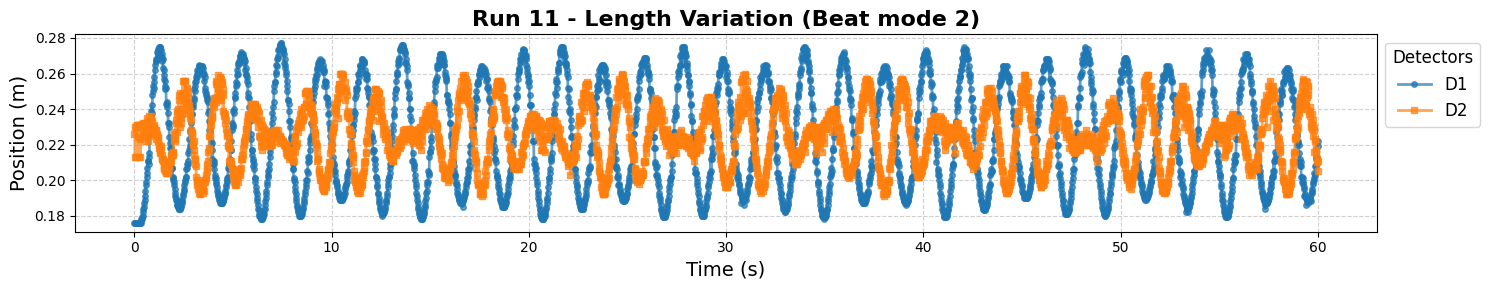

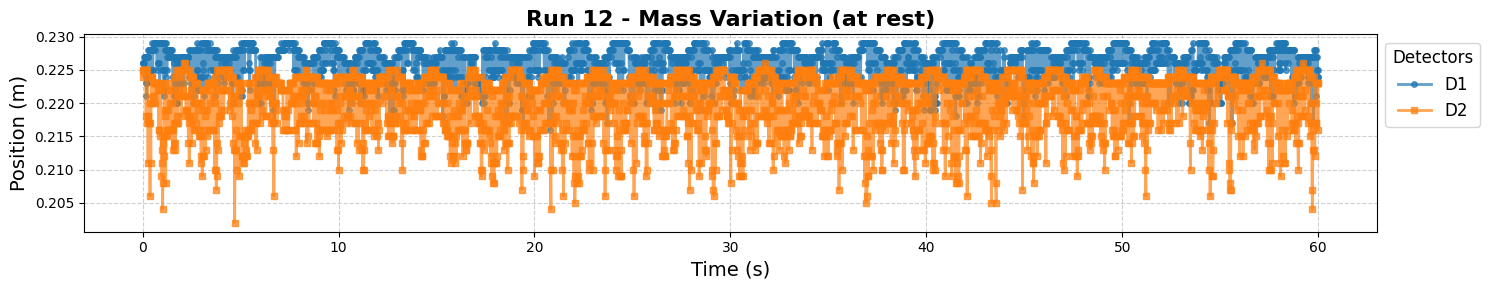

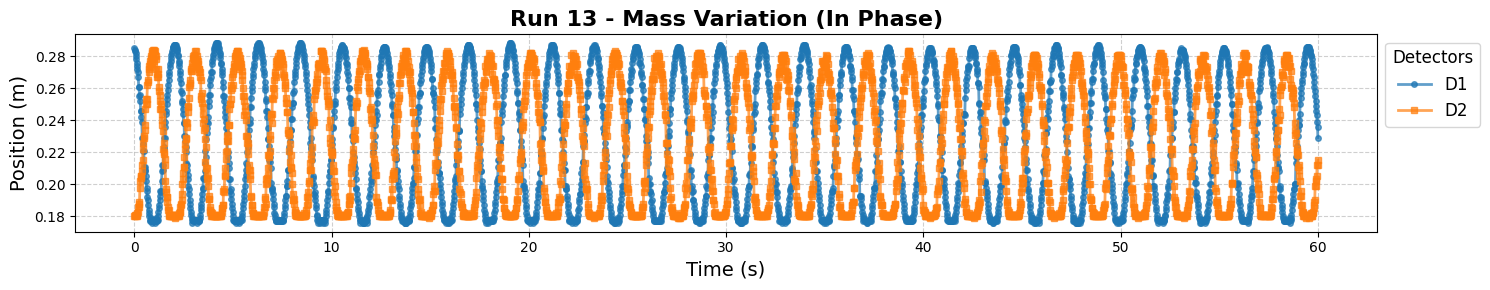

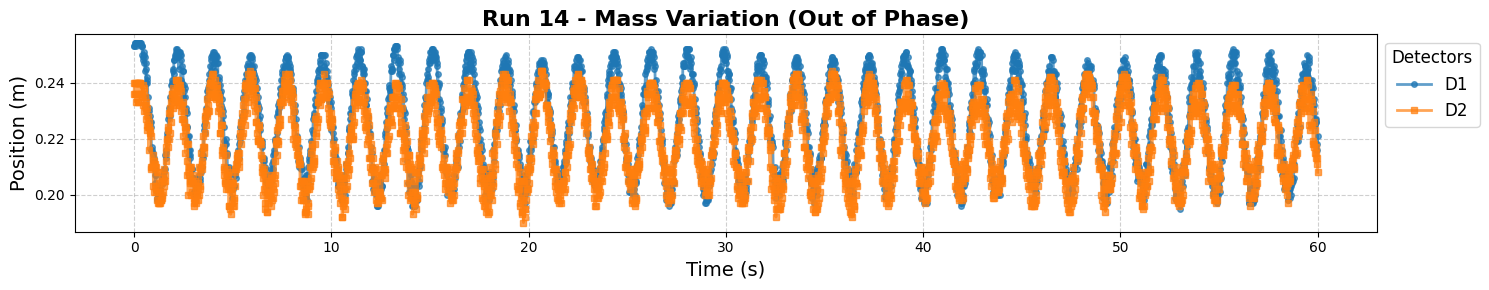

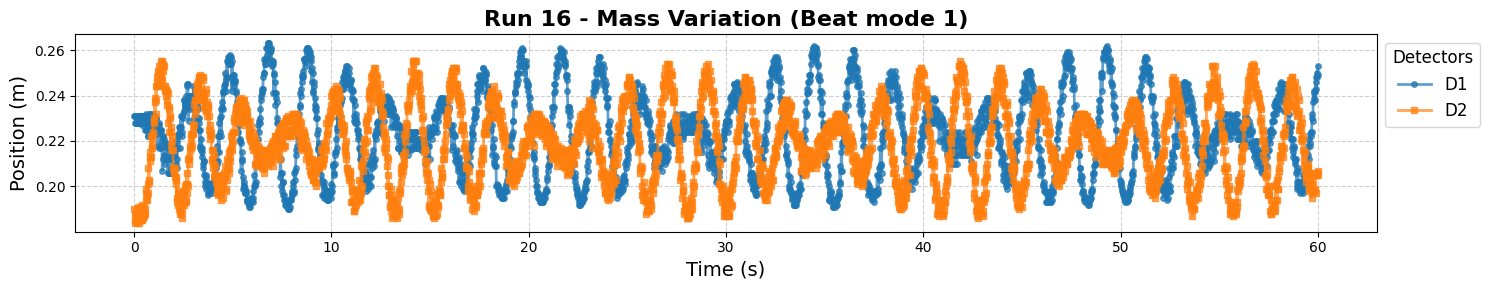

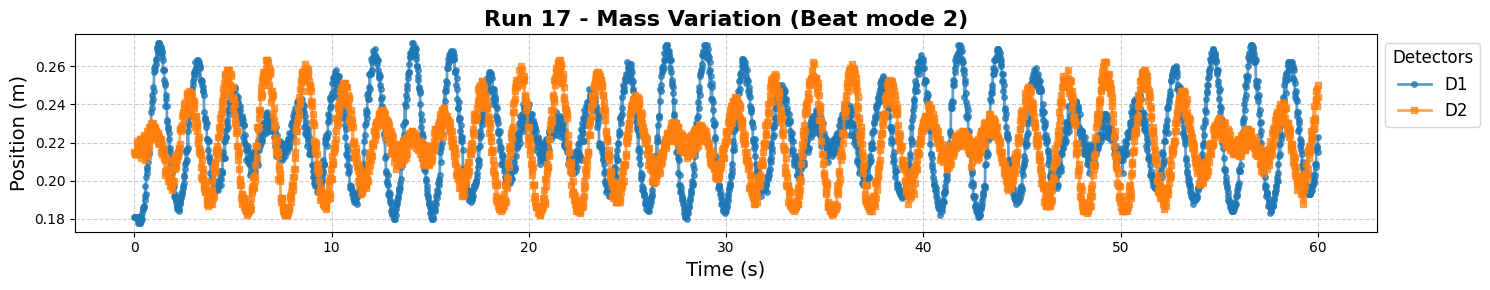

In [8]:
for i in [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17]:
    # Load Run 1 data
    df = pd.read_csv(f"runs_csv/Run_{i}.csv", sep="\t")

    df = df.apply(pd.to_numeric)

#     print("Columns:", df.columns.tolist())

    plt.figure(figsize=(15,3))

    plt.plot(df["Time"], df["Position"], label="D1", linewidth=2, marker="o", markersize=4, alpha=0.7)
    plt.plot(df["Time"], df["Position.1"], label="D2", linewidth=2, marker="s", markersize=4, alpha=0.7)

    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Position (m)", fontsize=14)
    plt.title(f"Run {i} - {data_titles[f'Run {i}']}", fontsize=16, fontweight="bold")

    plt.grid(True, linestyle="--", alpha=0.6)

    plt.legend(title="Detectors", fontsize=12, title_fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))

    plt.tight_layout()

    plt.show()

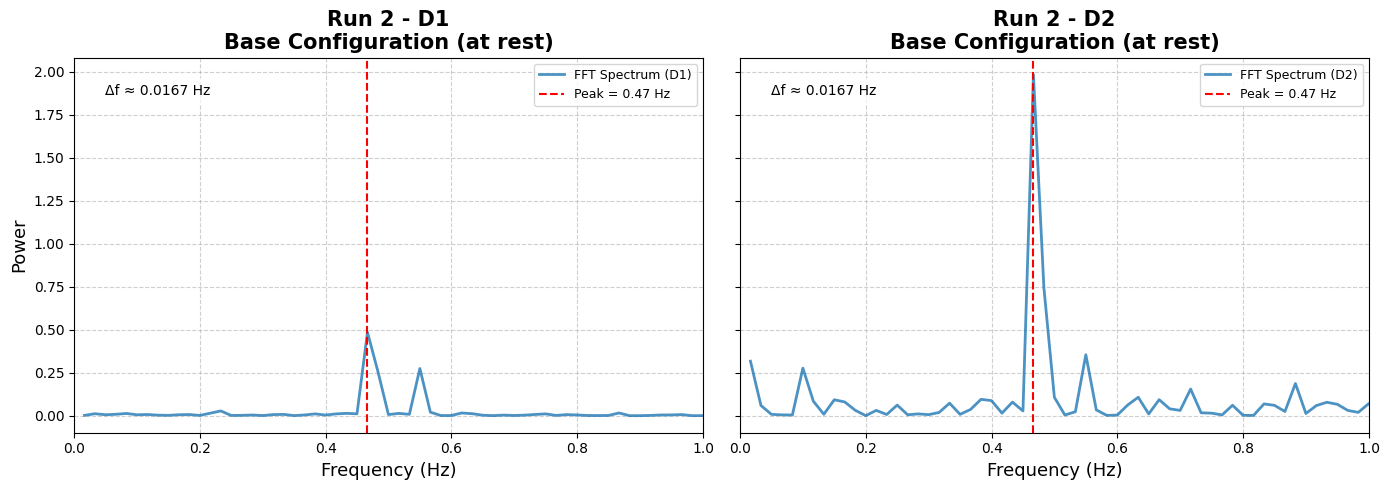

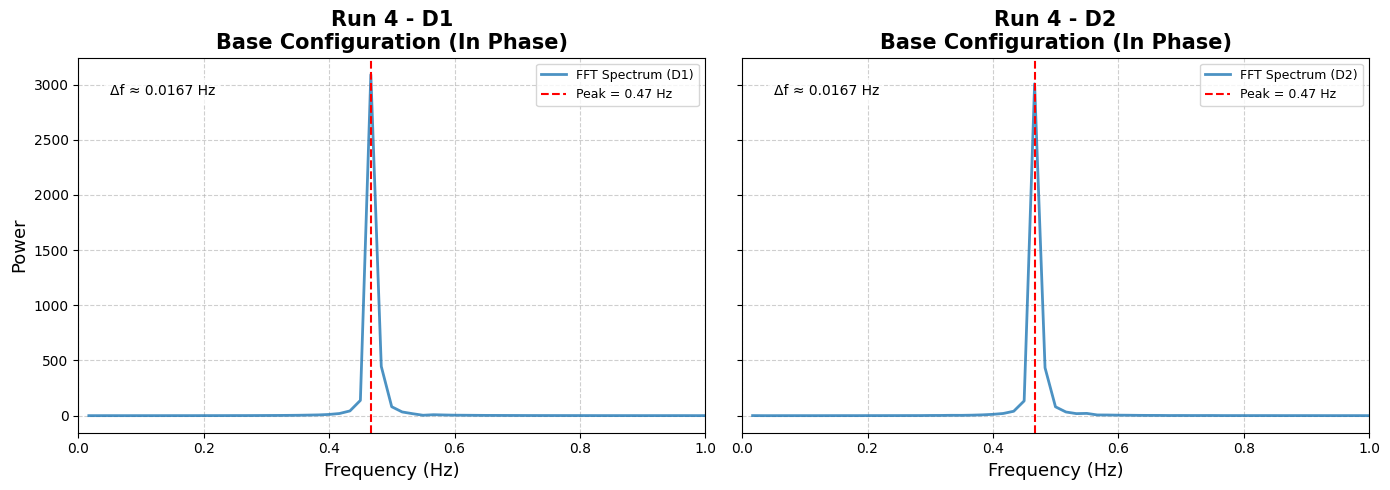

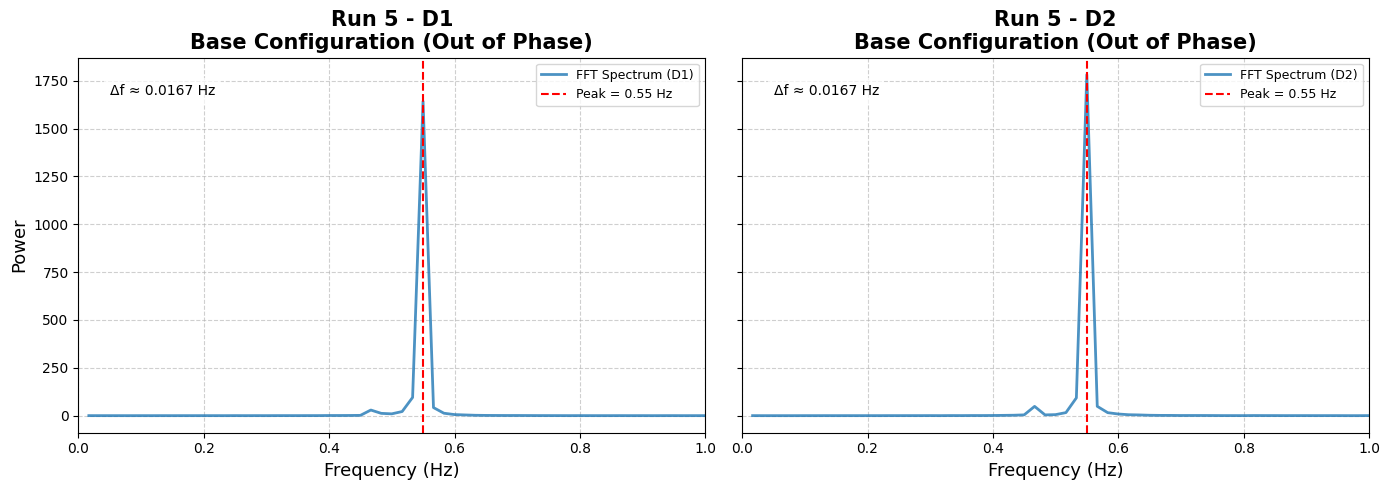

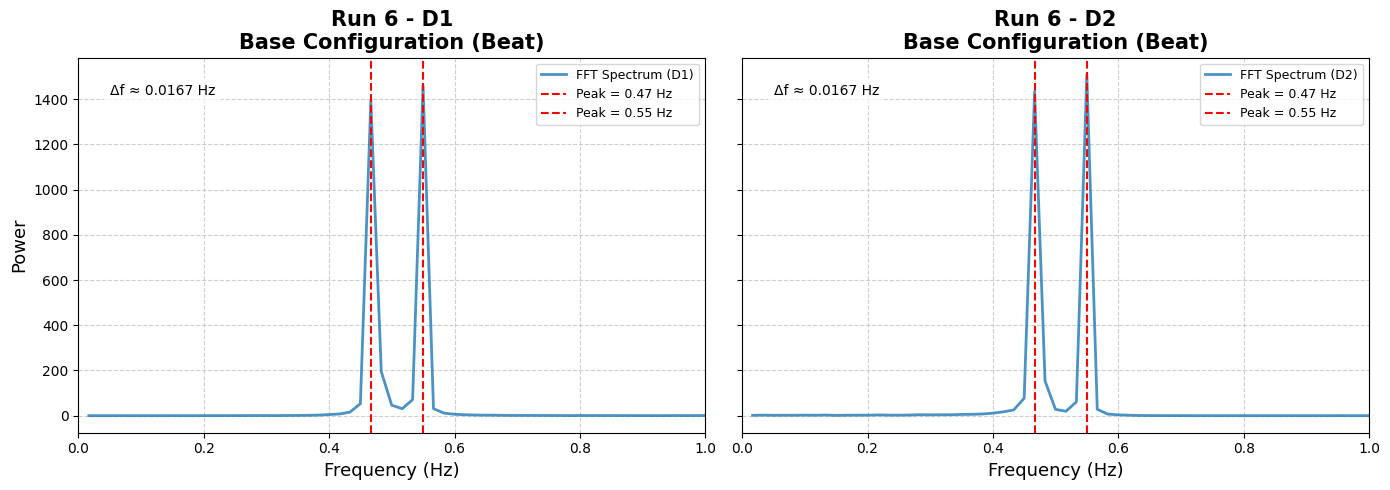

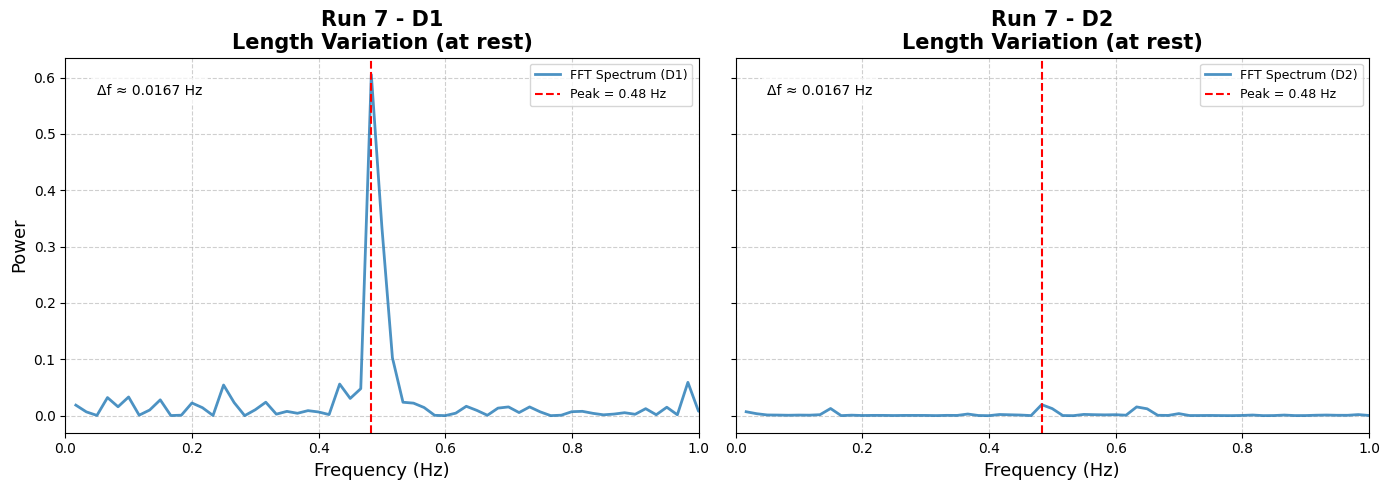

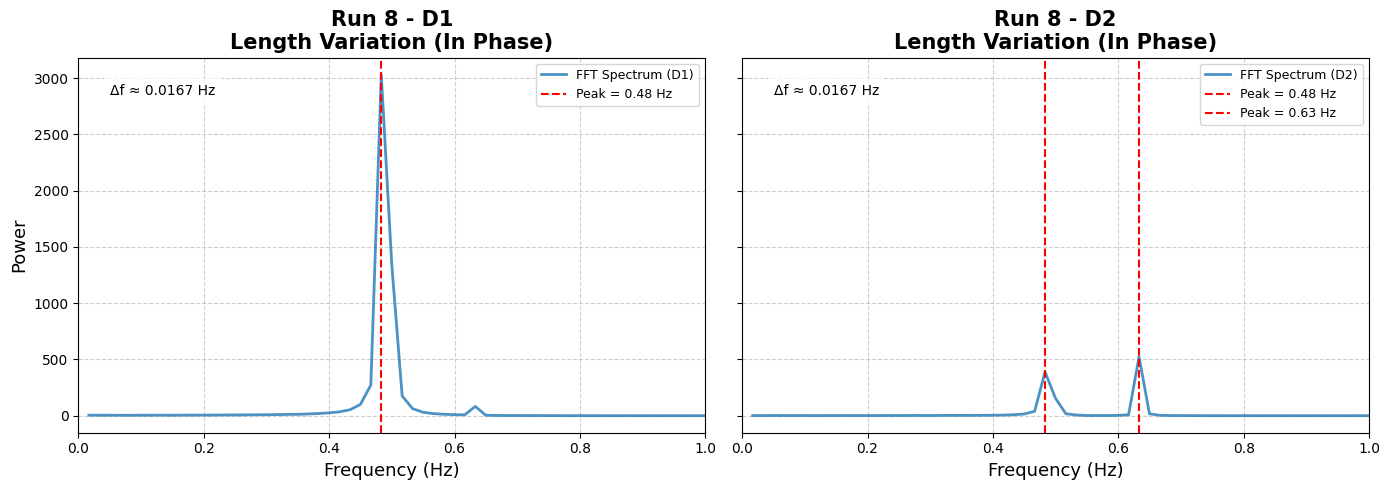

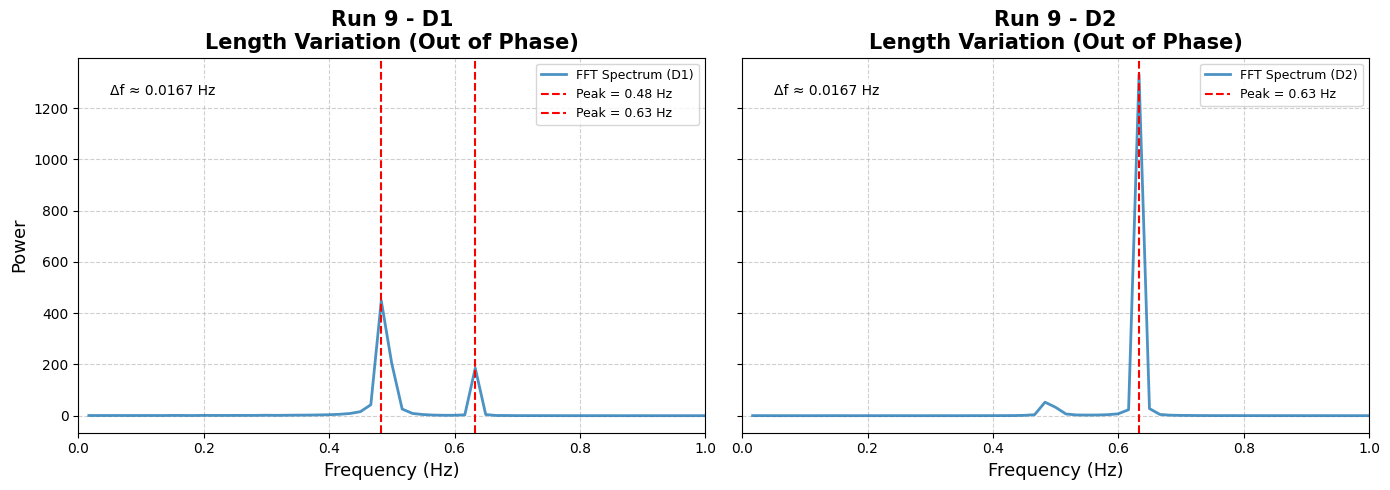

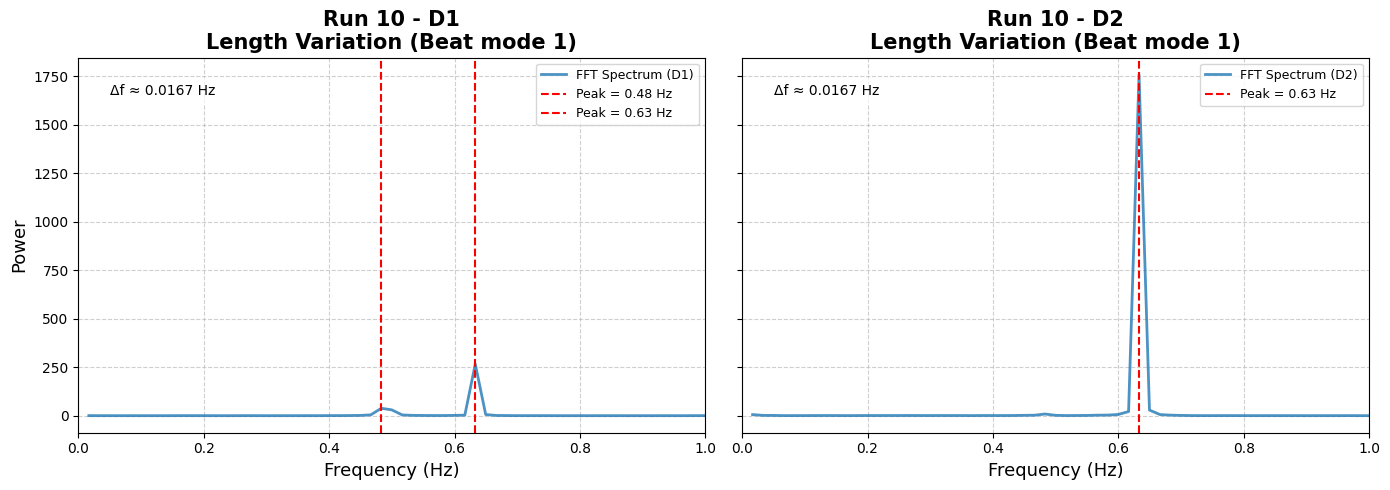

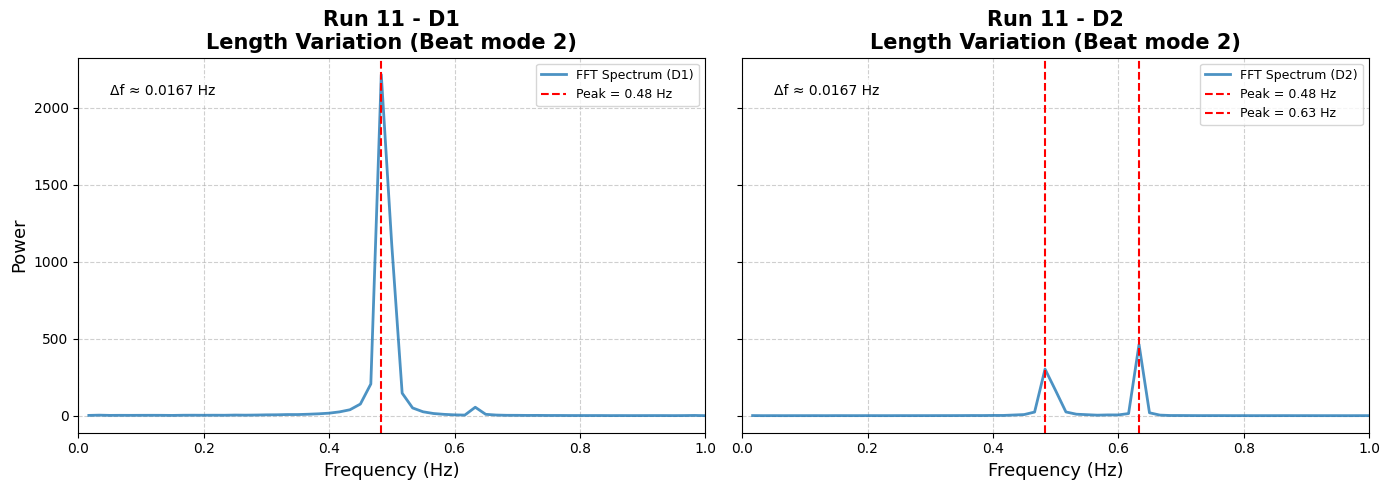

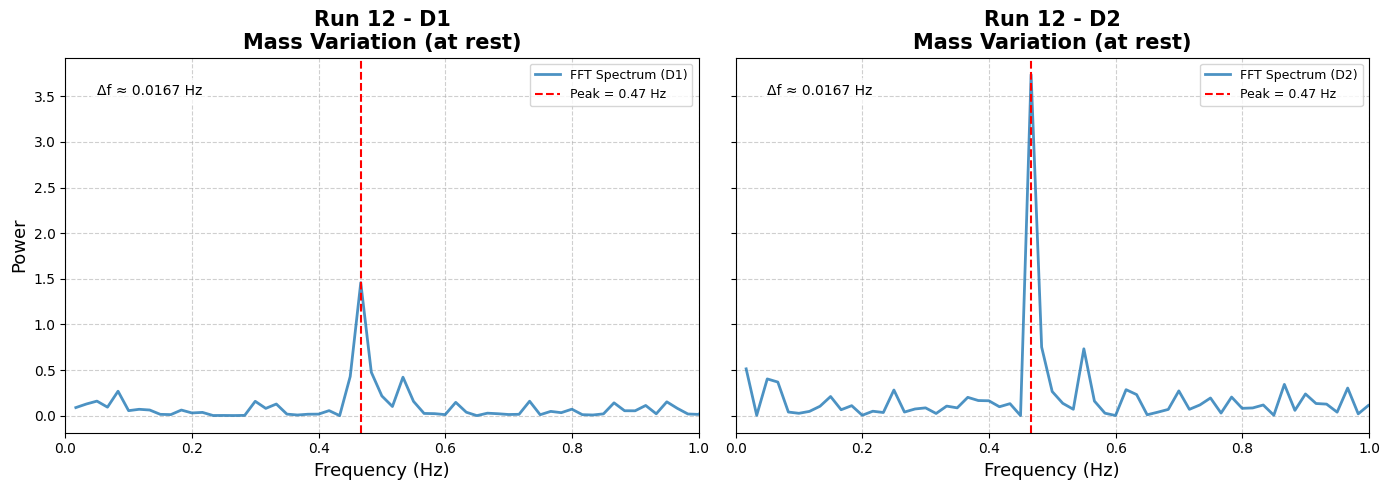

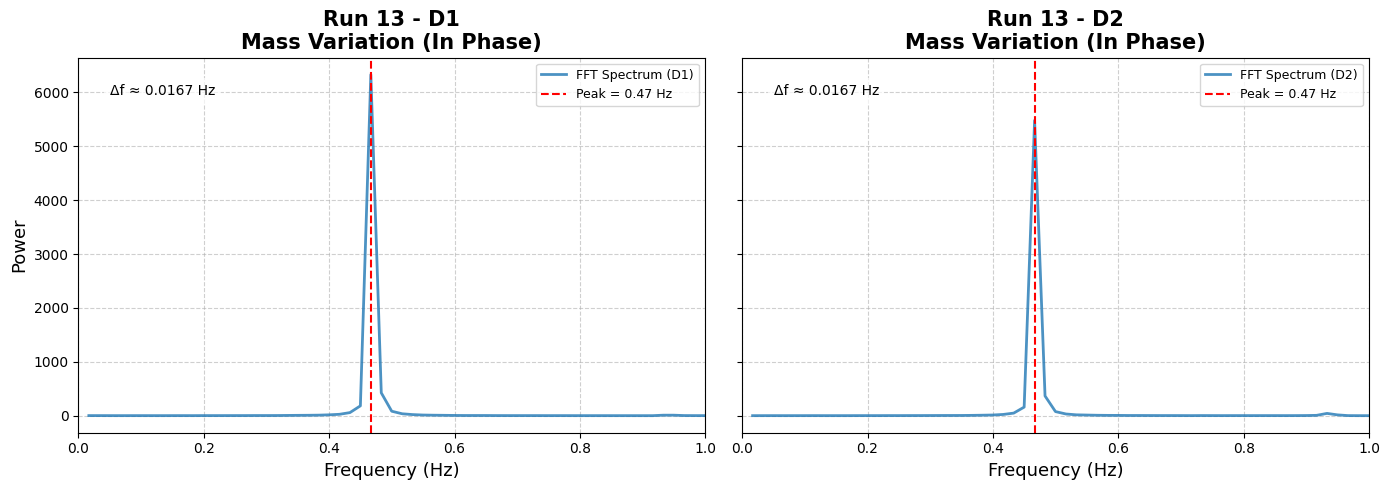

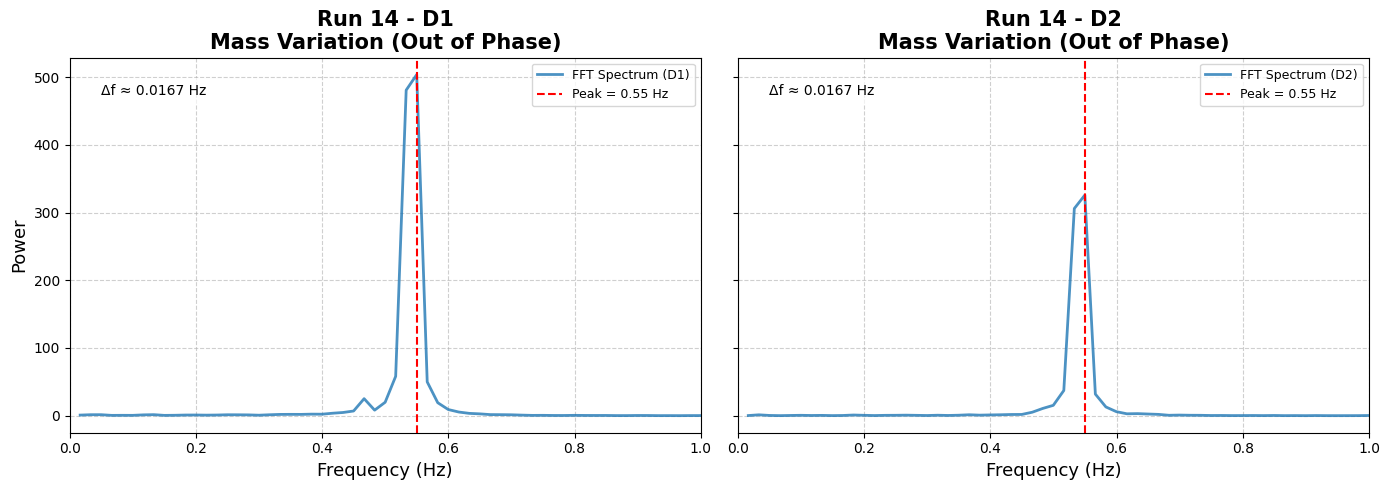

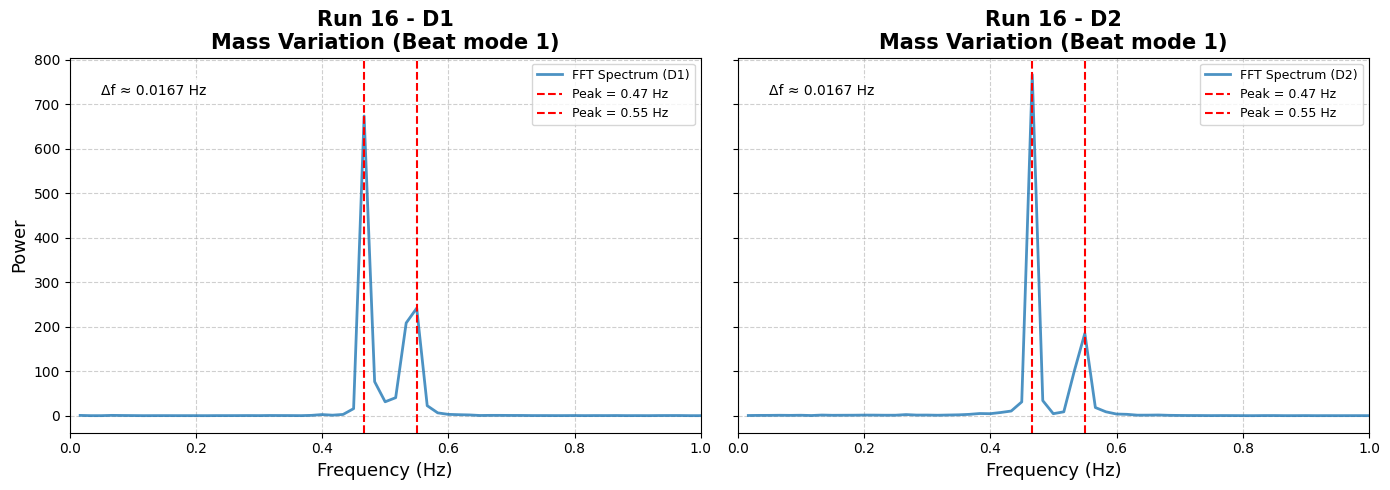

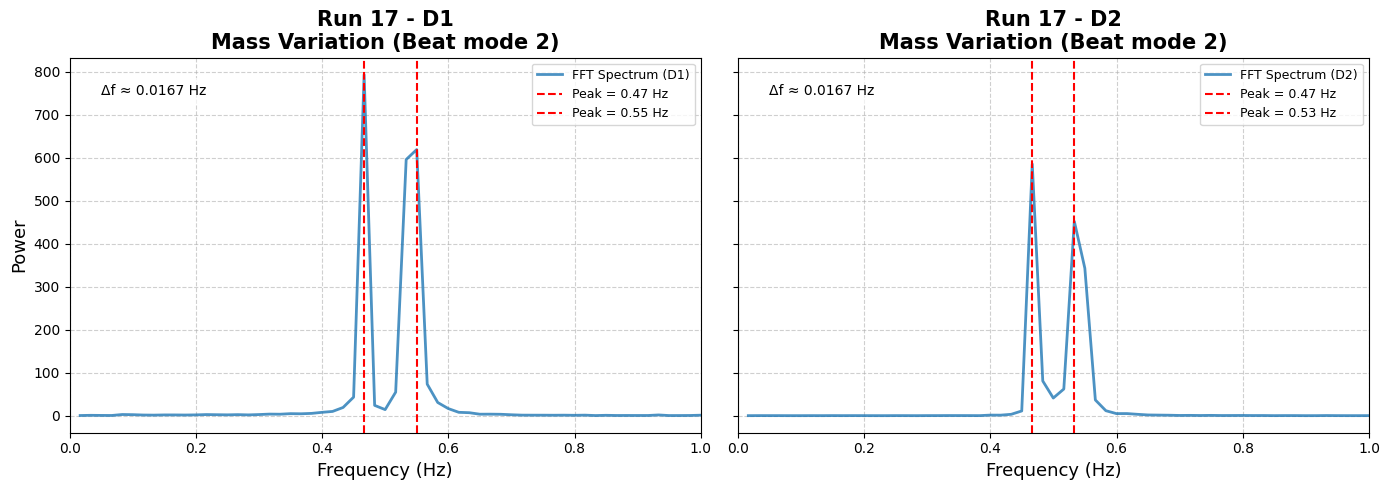

In [14]:
for i in [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17]:
    df = pd.read_csv(f"runs_csv/Run_{i}.csv", sep="\t")
    df = df.apply(pd.to_numeric)

    time = df["Time"].values
    d1 = df["Position"].values
    d2 = df["Position.1"].values
    
    d1_freq, d1_power = fft_calc(time, d1)
    d2_freq, d2_power = fft_calc(time, d2)

    if i in [2, 7, 12]:
        peak_idx_d1 = [np.argmax(d1_power)]
        peak_idx_d2 = [np.argmax(d2_power)]
        
        # Calculate Initial Condition uncertainty
    else:
        peak_idx_d1, _ = find_peaks(d1_power, height=np.max(d1_power)*0.1)
        peak_idx_d2, _ = find_peaks(d2_power, height=np.max(d2_power)*0.1)

    dom_freqs_d1 = d1_freq[peak_idx_d1]
    dom_freqs_d2 = d2_freq[peak_idx_d2]

    T_total = time[-1] - time[0]
    freq_uncertainty = 1.0 / T_total

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    plot_kwargs = dict(linewidth=2, alpha=0.8)

    # Left plot (D1)
    axes[0].plot(d1_freq, d1_power, **plot_kwargs, label="FFT Spectrum (D1)")
    for f in dom_freqs_d1:
        axes[0].axvline(f, color="r", linestyle="--", linewidth=1.5,
                        label=f"Peak = {f:.2f} Hz")
    axes[0].set_xlabel("Frequency (Hz)", fontsize=13)
    axes[0].set_ylabel("Power", fontsize=13)
    axes[0].set_title(f"Run {i} - D1\n{data_titles[f'Run {i}']}",
                      fontsize=15, fontweight="bold")
    axes[0].legend(fontsize=9, loc="upper right")
    axes[0].grid(True, linestyle="--", alpha=0.6)
    axes[0].set_xlim(0, 1)
    axes[0].text(0.05, 0.9, f"Δf ≈ {freq_uncertainty:.4f} Hz",
                 transform=axes[0].transAxes, fontsize=10,
                 bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    # Right plot (D2)
    axes[1].plot(d2_freq, d2_power, **plot_kwargs, label="FFT Spectrum (D2)")
    for f in dom_freqs_d2:
        axes[1].axvline(f, color="r", linestyle="--", linewidth=1.5,
                        label=f"Peak = {f:.2f} Hz")
    axes[1].set_xlabel("Frequency (Hz)", fontsize=13)
    axes[1].set_title(f"Run {i} - D2\n{data_titles[f'Run {i}']}",
                      fontsize=15, fontweight="bold")
    axes[1].legend(fontsize=9, loc="upper right")
    axes[1].grid(True, linestyle="--", alpha=0.6)
    axes[1].set_xlim(0, 1)
    axes[1].text(0.05, 0.9, f"Δf ≈ {freq_uncertainty:.4f} Hz",
                 transform=axes[1].transAxes, fontsize=10,
                 bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    plt.tight_layout()
    plt.show()